In [1]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cf
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import gribscan
import intake
import eccodes
import healpy as hp

Open the catalog with nextGEMS data

In [2]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")

In [3]:
data_ifs = cat.IFS['IFS_9-FESOM_5-production']['2D_hourly_healpix512'].to_dask() 

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


In [4]:
data_icon = cat.ICON['ngc4008'](time="PT3H", zoom=9).to_dask()

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


In [5]:
data_ifs_oce = cat.IFS['IFS_9-FESOM_5-production']['2D_daily_healpix512_ocean'].to_dask() 

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


In [6]:
data_ifs_oce_3d = cat.IFS['IFS_9-FESOM_5-production']['3D_daily_healpix512_ocean'].to_dask() 

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


In [7]:
data_icon_oce = cat.ICON['ngc4008'](time="P1D", zoom=9).to_dask()

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


## One point data

In [8]:
data_example = data_ifs['2t'][-1,:]

The length is 3145728, so it's zoom level 9

In [9]:
len(data_example)

3145728

We start by selecting data for the point. We can find index in healpix mesh, that is closest to our point. It will be the same for both models:

In [10]:
pix = hp.ang2pix(
        hp.npix2nside(len(data_example)), theta=9.98737477, phi=49.70353785, nest=True, lonlat=True
    )

In [11]:
pix

178005

In [12]:
%%time
point_data = data_ifs['2t'].sel(time='2030')[:,pix].compute()

CPU times: user 9min 20s, sys: 1min 41s, total: 11min 1s
Wall time: 25.3 s


We select the same number of time steps (8 time steps more actually :))

In [13]:
data_icon['tas'].sel(time=slice('2030', '2032'))

<xarray.DataArray 'tas' (time: 8768, cell: 3145728)>
[27581743104 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2030-01-01 ... 2032-12-31T21:00:00
Dimensions without coordinates: cell
Attributes:
    cell_methods:   time: mean cell: mean
    component:      atmo
    grid_mapping:   crs
    long_name:      temperature in 2m
    standard_name:  air_temperature
    units:          K
    vgrid:          height_2m

In [14]:
%%time
point_data_icon = data_icon['tas'].sel(time=slice('2030', '2032'))[:,pix].compute()

CPU times: user 275 ms, sys: 252 ms, total: 527 ms
Wall time: 1.9 s


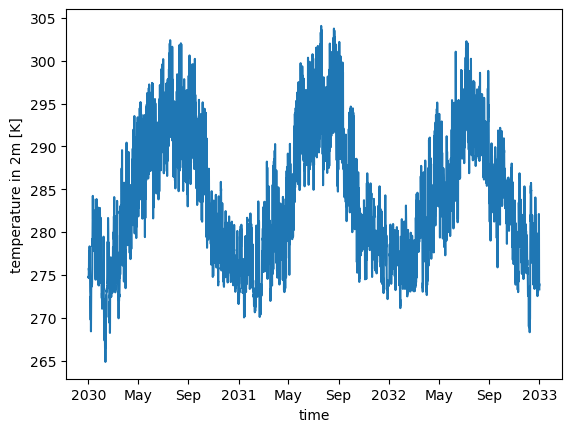

In [15]:
point_data_icon.plot()

## 30 random points

In [16]:
import random

random.seed(42)  # Set a seed for reproducibility
random_numbers = [random.randint(0, 10000) for _ in range(30)]

print(random_numbers)

[1824, 409, 4506, 4012, 3657, 2286, 1679, 8935, 1424, 9674, 6912, 520, 488, 1535, 3582, 3811, 8279, 9863, 434, 9195, 3257, 8928, 6873, 3611, 7359, 9654, 4557, 106, 2615, 6924]


Only surface here to compare with earthkit

In [17]:
%%time
transect_fesom = data_ifs_oce_3d['avg_thetao'].sel(time='2030')[:,0,random_numbers].compute()

CPU times: user 31.5 s, sys: 33.3 s, total: 1min 4s
Wall time: 5.25 s


In [18]:
%%time
transect_icon = data_icon_oce['to'].sel(time='2030')[:,0,random_numbers].compute()

CPU times: user 246 ms, sys: 108 ms, total: 355 ms
Wall time: 776 ms


## Small polygon

In [19]:
# 5° × 5° polygon over central Europe
# Split into separate longitude and latitude lists

# Extract coordinates
lats = [45.0, 50.0, 50.0, 45.0]  # Latitude values (phi)
lons = [0.0, 0.0, 5.0, 5.0]       # Longitude values (theta)

# Example usage with healpy (hp)
vec = hp.ang2vec(theta=lons, phi=lats, lonlat=True)

In [20]:
ipix_poly = hp.query_polygon(hp.npix2nside(len(data_example)), vertices=vec, inclusive=False, nest=True)

In [21]:
%%time
poly_ifs = data_ifs['2t'].sel(time='2030')[:,ipix_poly].compute()

CPU times: user 11min 9s, sys: 1min 40s, total: 12min 50s
Wall time: 35.8 s


In [22]:
%%time
poly_icon = data_icon['tas'].sel(time=slice('2030', '2032'))[:,ipix_poly].compute()

CPU times: user 450 ms, sys: 223 ms, total: 673 ms
Wall time: 1.71 s


## SSH variability

In [8]:
%%time

ssh = data_ifs_oce['avg_zos'].std(dim='time').compute()

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 51min 18s, sys: 2h 12min 30s, total: 3h 3min 48s
Wall time: 6min 43s


In [ ]:
%%time
ssh_icon = data_icon_oce['zos'].std(dim='time').compute()

## Range (consecutive points)

Let's take some area, for simplicity just represented by first 100K points

In [23]:
%%time
area_data = data_ifs['2t'].sel(time='2030')[:,list(range(100000))].mean(dim='value').compute()

CPU times: user 10min 50s, sys: 1min 49s, total: 12min 40s
Wall time: 43.5 s


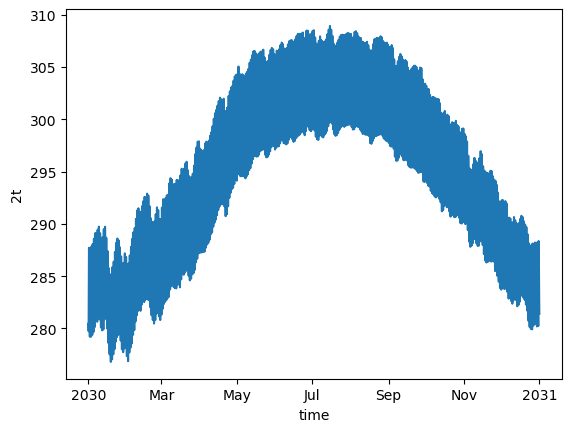

In [24]:
area_data.plot()

Same for ICON

In [25]:
%%time
area_data_icon = data_icon['tas'].sel(time=slice('2030', '2032'))[:,list(range(100000))].mean(dim='cell').compute()

CPU times: user 8.25 s, sys: 4.26 s, total: 12.5 s
Wall time: 27.4 s


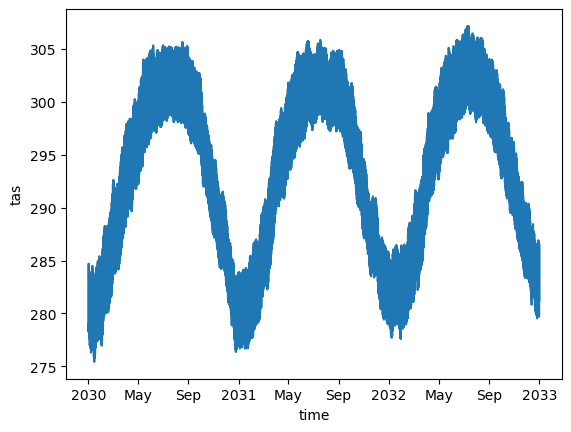

In [26]:
area_data_icon.plot()

Now let's take some ocean data

## 3D ocean, hovmouller diagram

Let's try 3D ocean (sorry, I am oncean guy :))

We will study mixed layer behaviour. We will select point in the middle of Atlantic, and will try to plot hovmouller diagram of first 10 levels for every time step.

In [27]:
pix = hp.ang2pix(
        hp.npix2nside(len(data_example)), theta=-45, phi=30, nest=True, lonlat=True
    )

In [28]:
pix

842410

We only going to compute for 365 values

In [29]:
%%time
hovm = data_ifs_oce_3d['avg_thetao'].sel(time='2030')[:,0:10,pix].compute()

CPU times: user 4min 36s, sys: 1min 31s, total: 6min 8s
Wall time: 23.9 s


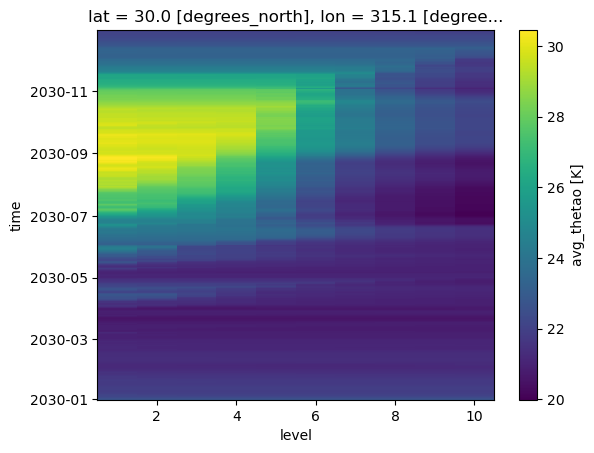

In [30]:
hovm.plot()

In [31]:
%%time
hovm_icon = data_icon_oce['to'].sel(time='2030')[:,0:10,pix].compute()

CPU times: user 745 ms, sys: 843 ms, total: 1.59 s
Wall time: 6.75 s


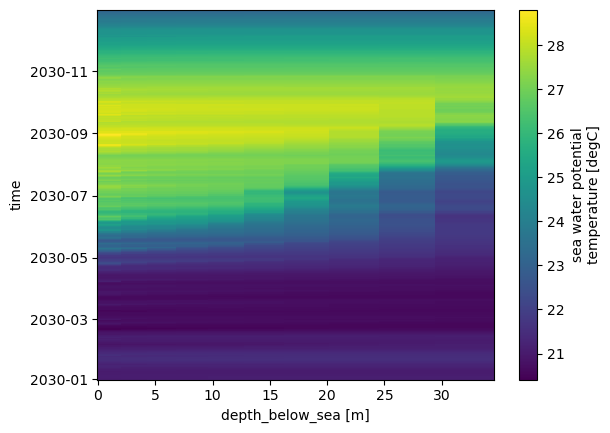

In [32]:
hovm_icon.plot()

## A bit more random data access

Random data access, emulating transect or just bunch of vertical profiles across the ocean

In [40]:
import random

random.seed(42)  # Set a seed for reproducibility
random_numbers = [random.randint(0, 10000) for _ in range(30)]

print(random_numbers)

[1824, 409, 4506, 4012, 3657, 2286, 1679, 8935, 1424, 9674, 6912, 520, 488, 1535, 3582, 3811, 8279, 9863, 434, 9195, 3257, 8928, 6873, 3611, 7359, 9654, 4557, 106, 2615, 6924]


We increase the number of vertical levels to 30

In [43]:
%%time
transect = ocean_3D['avg_thetao'].sel(time='2030')[:,0:30,random_numbers].compute()

CPU times: user 47.1 s, sys: 3.46 s, total: 50.5 s
Wall time: 1min 22s


In [44]:
%%time
transect_icon = icon_ocean['to'].sel(time='2030')[:,0:30,random_numbers].compute()

CPU times: user 426 ms, sys: 52.3 ms, total: 478 ms
Wall time: 936 ms


## Ocean mean speed

In [6]:
import numpy as np

In [12]:
%%time
speed_mean = np.hypot(ocean_3D['avg_uoe'].sel(time='2030')[:,:30,:], ocean_3D['avg_von'].sel(time='2030')[:,:30,:]).mean(dim='time').compute()

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 55.06 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2025-02-11 21:27:03,224 - distributed.worker.memory - WARNING - gc.collect() took 1.064s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.


CPU times: user 3min 2s, sys: 16.3 s, total: 3min 19s
Wall time: 6min 12s


In [11]:
%%time
speed_mean_icon = np.hypot(icon_ocean['u'].sel(time='2030')[:,:30,:], icon_ocean['v'].sel(time='2030')[:,:30,:]).mean(dim='time').compute()

CPU times: user 32.1 s, sys: 2.97 s, total: 35.1 s
Wall time: 1min 32s
